In [1]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227137 sha256=8d925ad4b2a75a2ee32e2e9c457f1ec78d3521df476ed2cd532d0b25b0bf2388
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [4]:
!pip install python-louvain
!pip install glove-python3
!pip install kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.7 MB/s eta 0:00:00


In [1]:
import pandas as pd
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
import community.community_louvain as community_louvain
import fasttext.util
from tqdm import tqdm
from gensim.models import FastText
from gensim.test.utils import common_texts
from glove import Corpus, Glove

## Data Preparation

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_parquet('/content/drive/MyDrive/comp_final_5years.parquet')

In [3]:
df_short = df[['header', 'company', 'text_clear']]

In [4]:
df_short

header company  \
0                          Экстренная посадка в регионах    SBER   
1                          Экстренная посадка в регионах    VTBR   
2                          Экстренная посадка в регионах    AFLT   
3      "Дочка" Сбербанка назвала штраф украинского ЦБ...    SBER   
4      Газпром - Северный поток-2 заработает с 1 янва...    GAZP   
...                                                  ...     ...   
50286  🔶IR Газпром: Группа «Газпром» консолидировала ...    GAZP   
50287  ГПБ стал совладельцем завода СПГ "Газпрома" у ...    GAZP   
50288  Сооснователь Fix Price Хачатрян продал свою до...    FIXP   
50289  ЦБ РФ оценит трансграничные переводы физлиц, с...    QIWI   
50290   Сооснователь Fix Price Хачатрян продал свою долю    FIXP   

                                              text_clear  
0      итог год российский авиарынок москва январь in...  
1      итог год российский авиарынок москва январь in...  
2      итог год российский авиарынок москва январь in...  
3      украинский дочка сбербанк назвать штраф национ...  
4      глава газпром алексей миллер рассказать интерв...  
...                                                  ...  
50286  релиз группа газпром консолидировать контрольн...  
50287  группа газпромбанк стать совладелец среднетонн...  
50288  сооснователь fix price артем хачатряна выйти к...  
50289  банк россия январефеврал год провести обследов...  
50290  сооснователь fix price артем хачатряна продать...  

[50291 rows x 3 columns]

In [5]:
aggregate_text = df_short.groupby('company')['text_clear'].apply(lambda x: " ".join(x))

In [6]:
texts = list(aggregate_text.values)
entities = list(aggregate_text.index)

In [7]:
node_classes = {
    # Нефть и газ
    'MOEXOG':
    ['BANE', 'GAZP', 'LKOH', 'NVTK', 'RNFT', 'ROSN', 'SNGS', 'TATN', 'TRNF'],
    # Электроэнергетики
    'MOEXEU': [
        'IRAO', 'HYDR', 'FEES', 'MSNG', 'UPRO', 'LSNG', 'RSTI', 'OGKB', 'MRKP',
        'MRKC', 'ELFV', 'TGKA', 'MSRS', 'MRKU', 'TGKB', 'DVEC', 'MRKZ', 'MRKV'
    ],
    # Телекоммуникации
    'MOEXTL': ['MTSS', 'RTKM', 'MGTS', 'TTLK'],
    # Металлы и добыча
    'MOEXMM': [
        'GMKN', 'PLZL', 'CHMF', 'NLMK', 'POLY', 'ALRS', 'MAGN', 'RUAL', 'ENPG',
        'MTLR', 'VSMO', 'SELG', 'RASP', 'SGZH', 'CHMK'
    ],
    # Финансы
    'MOEXFN':
    ['SBER', 'TCSG', 'VTBR', 'CBOM', 'BSPB', 'QIWI', 'RENI', 'SFIN', 'AFKS'],
    # Потребительский сектор
    'MOEXCN': [
        'MGNT', 'FIVE', 'FIXP', 'AGRO', 'GEMC', 'LENT', 'BELU', 'MDMG', 'AQUA',
        'MVID', 'APTK', 'SVAV', 'WUSH', 'ABIO', 'OKEY'
    ],
    # Химия и нефтехимия
    'MOEXCH': ['PHOR', 'KAZT', 'AKRN', 'NKNC', 'KZOS'],
    # Транспорт
    'MOEXTN': ['GLTR', 'FLOT', 'AFLT', 'NMTP', 'FESH', 'NKHP', 'RKKE'],
    # Информационные технологии
    'MOEXIT': ['CIAN', 'HHRU', 'OZON', 'POSI', 'VKCO', 'YNDX'],
    # Строительные компании
    'MOEXRE': ['ETLN', 'LSRG', 'PIKK', 'SMLT']
}

In [8]:
node_classes_new = {}
for keys,values in node_classes.items():
    for i in values:
        node_classes_new[i] = keys
print(node_classes_new)

{'BANE': 'MOEXOG', 'GAZP': 'MOEXOG', 'LKOH': 'MOEXOG', 'NVTK': 'MOEXOG', 'RNFT': 'MOEXOG', 'ROSN': 'MOEXOG', 'SNGS': 'MOEXOG', 'TATN': 'MOEXOG', 'TRNF': 'MOEXOG', 'IRAO': 'MOEXEU', 'HYDR': 'MOEXEU', 'FEES': 'MOEXEU', 'MSNG': 'MOEXEU', 'UPRO': 'MOEXEU', 'LSNG': 'MOEXEU', 'RSTI': 'MOEXEU', 'OGKB': 'MOEXEU', 'MRKP': 'MOEXEU', 'MRKC': 'MOEXEU', 'ELFV': 'MOEXEU', 'TGKA': 'MOEXEU', 'MSRS': 'MOEXEU', 'MRKU': 'MOEXEU', 'TGKB': 'MOEXEU', 'DVEC': 'MOEXEU', 'MRKZ': 'MOEXEU', 'MRKV': 'MOEXEU', 'MTSS': 'MOEXTL', 'RTKM': 'MOEXTL', 'MGTS': 'MOEXTL', 'TTLK': 'MOEXTL', 'GMKN': 'MOEXMM', 'PLZL': 'MOEXMM', 'CHMF': 'MOEXMM', 'NLMK': 'MOEXMM', 'POLY': 'MOEXMM', 'ALRS': 'MOEXMM', 'MAGN': 'MOEXMM', 'RUAL': 'MOEXMM', 'ENPG': 'MOEXMM', 'MTLR': 'MOEXMM', 'VSMO': 'MOEXMM', 'SELG': 'MOEXMM', 'RASP': 'MOEXMM', 'SGZH': 'MOEXMM', 'CHMK': 'MOEXMM', 'SBER': 'MOEXFN', 'TCSG': 'MOEXFN', 'VTBR': 'MOEXFN', 'CBOM': 'MOEXFN', 'BSPB': 'MOEXFN', 'QIWI': 'MOEXFN', 'RENI': 'MOEXFN', 'SFIN': 'MOEXFN', 'AFKS': 'MOEXFN', 'MGNT': '

In [9]:
texts_f_ft = [text.split() for text in texts]

## TF-IDF

In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

In [12]:
edges = []
similarity_mat = cosine_similarity(X)
for i in range(len(entities)):
    for j in range(i + 1, len(entities)):
        similarity = similarity_mat[i][j]
        if similarity > 0.7:
            edges.append((entities[i], entities[j], similarity))

In [10]:
def spectral_clusterization(G, k=9):
    A = nx.adjacency_matrix(G).todense()
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    L_norm = D_inv_sqrt @ L @ D_inv_sqrt
    eigvals, eigvecs = eigsh(L_norm, k=k, which='SM')
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(eigvecs)
    labels = kmeans.labels_
    res = {list(G.nodes)[i]: labels[i] for i in range(len(list(G.nodes)))}
    return res

In [11]:
def build_graph(edges, method, title, k=9):
    valid = ['louvin', 'spectral']
    if method not in valid:
        raise ValueError("results: status must be one of %r." % valid)

    G = nx.Graph()
    G.add_nodes_from(entities)
    G.add_weighted_edges_from(edges)
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)

    node_classes = node_classes_new

    # Определим цвета для классов
    class_colors = {
        'MOEXOG': 'rgba(51,51,51,1)',
        'MOEXEU': 'rgba(255,255,0,1)',
        'MOEXTL': 'rgba(102,0,153,1)',
        'MOEXMM': 'rgba(204,204,204,1)',
        'MOEXFN': 'rgba(0,153,0,1)',
        'MOEXCN': 'rgba(204,0,0,1)',
        'MOEXCH': 'rgba(204,255,0,1)',
        'MOEXTN': 'rgba(0,153,255,1)',
        'MOEXIT': 'rgba(0,51,204,1)',
        'MOEXRE': 'rgba(102,51,0,1)'
    }
    if method == 'louvin':
        partition = community_louvain.best_partition(G.to_undirected())
    else:
        partition = spectral_clusterization(G, k)

    # Получим координаты узлов с помощью spring layout
    pos = nx.kamada_kawai_layout(G)

    # Получим координаты для plotly
    edge_x = []
    edge_y = []
    weights = []
    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        weights.append(edge[2]['weight'])

    # Нормализуем веса для градиента
    weights = np.array(weights)
    norm_weights = (weights - weights.min()) / (weights.max() - weights.min())

    # Создадим фигуру
    fig = go.Figure()

    # Добавим грани с градиентом
    for i in range(len(edge_x)//3):
        fig.add_trace(go.Scatter(
            x=edge_x[i*3:(i+1)*3],
            y=edge_y[i*3:(i+1)*3],
            line=dict(width=2, color=f'rgba(0,0,255,{norm_weights[i]})'),
            hoverinfo='none',
            mode='lines',
            showlegend=False
        ))

    # Определим цвета для кластеров
    clusters = list(set(partition.values()))
    cluster_colors = {cluster: f'rgba({np.random.randint(0, 255)}, {np.random.randint(0, 255)}, {np.random.randint(0, 255)}, 0.3)' for cluster in clusters}

    # Добавим области для кластеров
    for cluster in clusters:
        cluster_nodes = [node for node in G.nodes if partition[node] == cluster]
        if len(cluster_nodes) > 2:
            cluster_pos = np.array([pos[node] for node in cluster_nodes])
            hull = ConvexHull(cluster_pos)
            hull_pts = cluster_pos[hull.vertices]
            hull_x = hull_pts[:, 0]
            hull_y = hull_pts[:, 1]
            fig.add_trace(go.Scatter(
                x=hull_x.tolist() + [hull_x[0]],
                y=hull_y.tolist() + [hull_y[0]],
                fill='toself',
                fillcolor=cluster_colors[cluster],
                line=dict(color='rgba(255,255,255,0)'),
                hoverinfo='none',
                mode='lines',
                showlegend=False
            ))

    # Добавим узлы с размерами, зависящими от количества связей и цветами согласно классу
    node_x = []
    node_y = []
    node_sizes = []
    node_colors = []
    node_texts = []
    for node in pos:
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_sizes.append(10 + (G.degree(node)))  # базовый размер 10, плюс 5 за каждую связь
        node_colors.append(class_colors[node_classes[node]])
        node_texts.append(f'Node {node}: Degree {G.degree(node)}, Class {node_classes[node]}')

    fig.add_trace(go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers+text',
        text=[f'{node}' for node in G.nodes],
        textposition='top center',
        marker=dict(size=node_sizes, color=node_colors),
        hoverinfo='text',
        name='Nodes',
        showlegend=False
    ))

    # Добавим легенду
    for node_class, color in class_colors.items():
        fig.add_trace(go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(size=10, color=color),
            legendgroup=node_class,
            showlegend=True,
            name=f'{node_class}'
        ))

    colorbar_trace = go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(
            size=10,
            color=[weights.min(), weights.max()],
            colorscale=[f'rgba(0,0,255,{sorted(norm_weights)[i]})' for i in range(len(edge_x)//3)],
            colorbar=dict(
                title='Cosine Similarity',
                titleside="right",
                tickvals=[weights.min(), weights.max()],
                ticktext=[round(weights.min(), 3), round(weights.max(), 3)],
                orientation='h',
                x=0.5,
                xanchor='center',
                y=-0.1,
                yanchor='top'
            )
        ),
        showlegend=False,
        hoverinfo='none'
    )

    fig.add_trace(colorbar_trace)


    # Настройки отображения
    fig.update_layout(showlegend=True, autosize=False, width=1200, height=750, title_text=title, legend_title_text='Industrial Indexes')
    fig.show(renderer='png')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



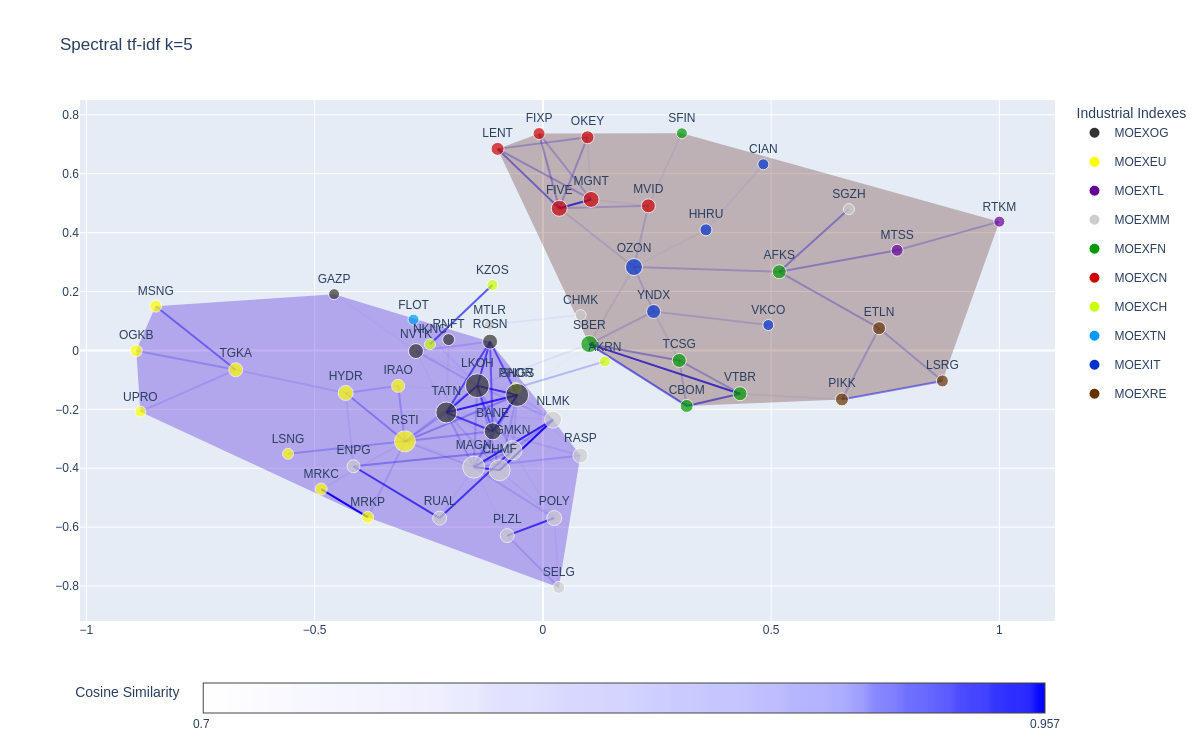

In [27]:
build_graph(edges, method='spectral', k=5, title='Spectral tf-idf k=5')

> Too large clusters, however it is clearly seen that there is a difference between consumer oriented companies and manufacturing companies.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



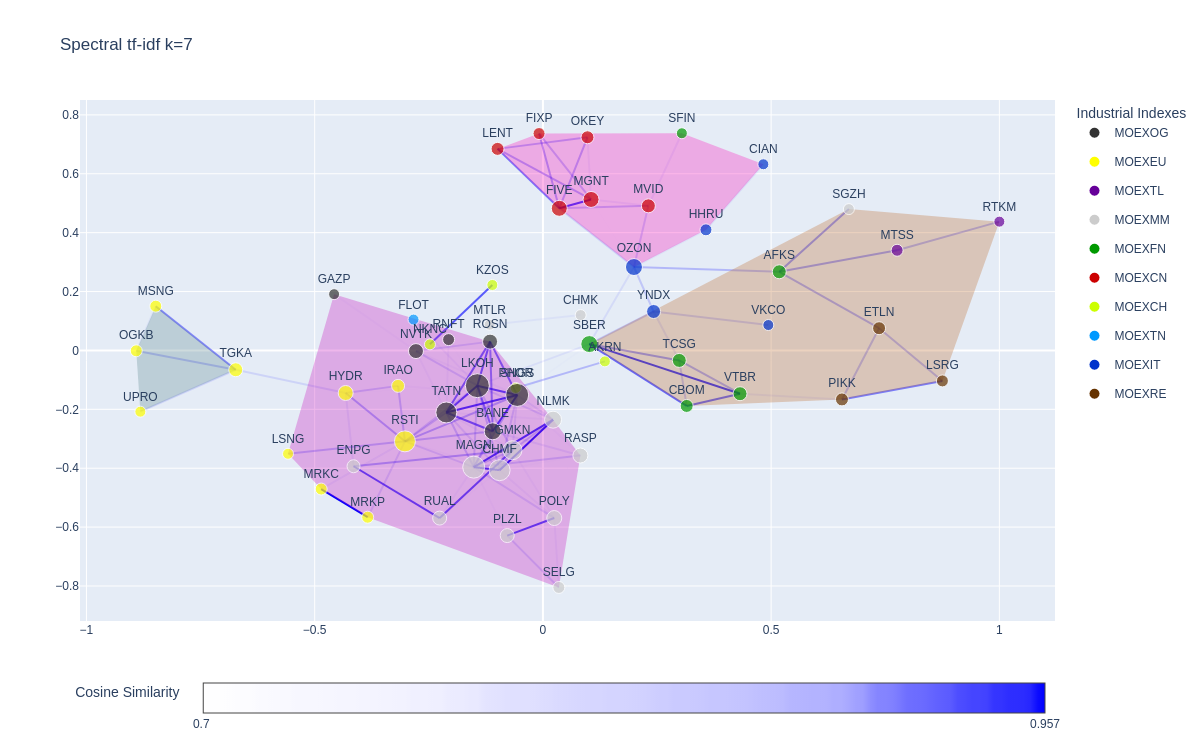

In [28]:
build_graph(edges, method='spectral', k=7, title='Spectral tf-idf k=7')

> Still one cluster for almost all manufacturing and electroenergy companies. There appears a difference between 2 groups of consumers oriented companies.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



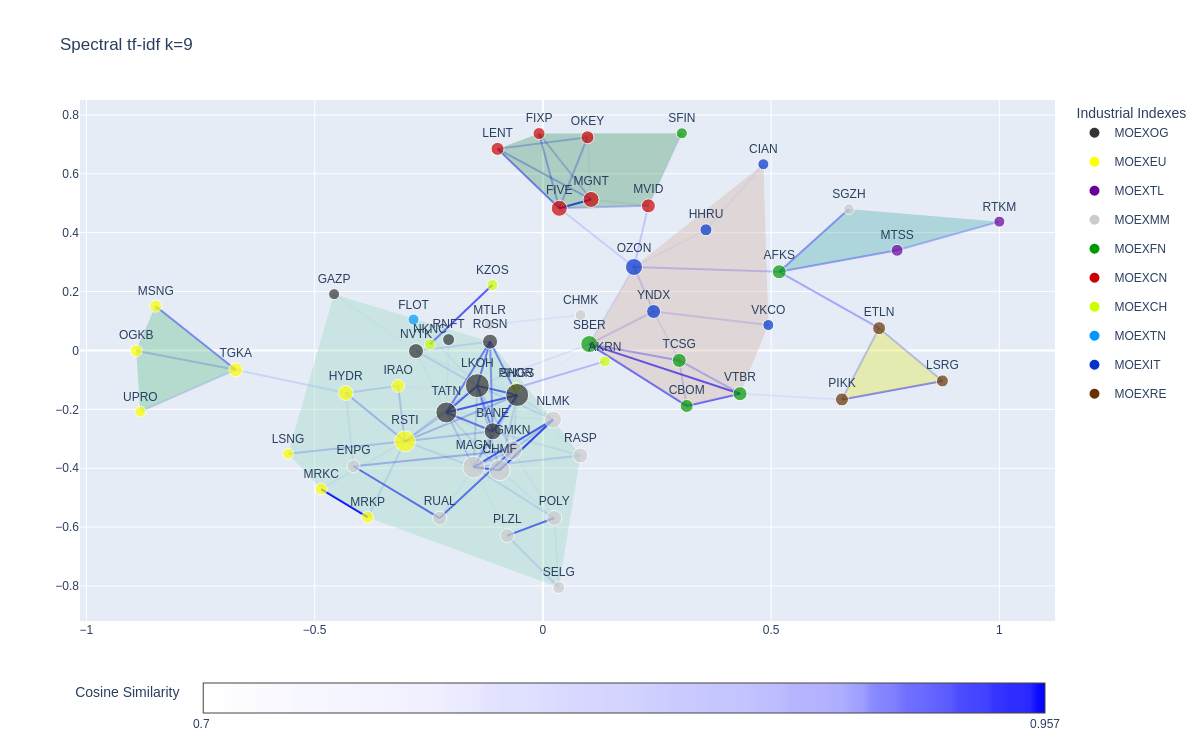

In [29]:
build_graph(edges, method='spectral', k=9, title='Spectral tf-idf k=9')

> Manufacturing side still holds together while consumer oriented side splits into different clusters, which can be explainable from the perspective of ownership, business profile and etc.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



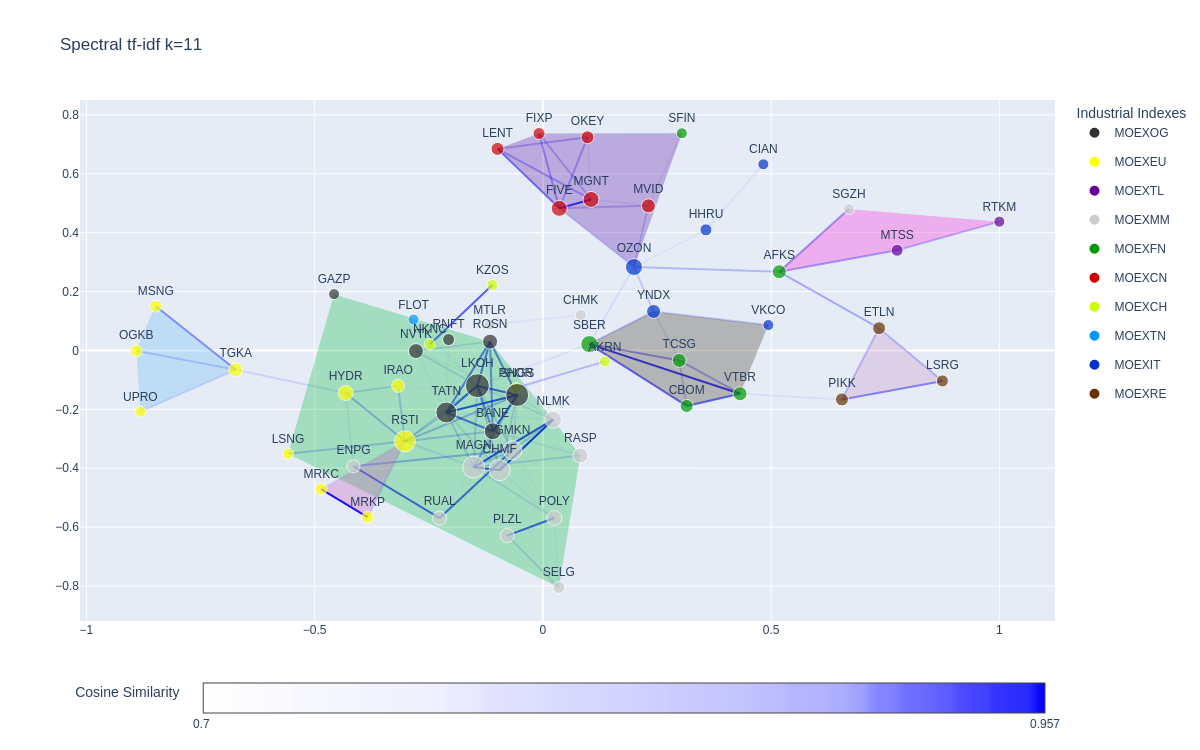

In [30]:
build_graph(edges, method='spectral', k=11, title='Spectral tf-idf k=11')

> No improvement, only own clusters of CIAN and HHRU appear

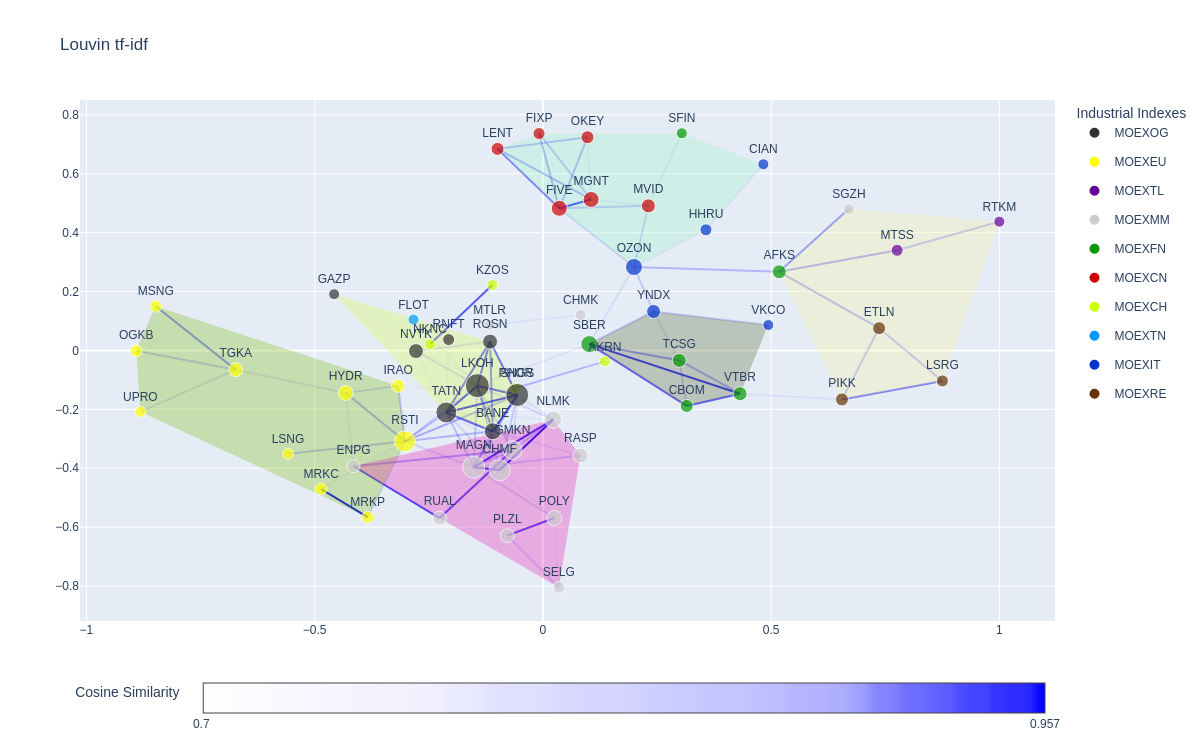

In [31]:
build_graph(edges, method='louvin', title='Louvin tf-idf')

> Louvin looks different as it splits manufacturers and electoenergy companies. Clusterization of consumer oriented compnies also looks a little different. Real estate companies somehow occured in same cluster as telecom.

> Tf-idf based graphs appear to be rather good, as there is a clear explanation behind each edge. These graphs allows us to split companies into several clusters in a way that make sense.

## Fasttext

In [18]:
fasttext.util.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

In [19]:
def get_text_embeddings(text):

    embeddings = [ft.get_word_vector(word) for word in text]
    return sum(embeddings) / len(embeddings)

In [20]:
X_emb = []

In [21]:
for text in tqdm(texts):
    text_embedding = get_text_embeddings(text.split())
    X_emb.append(text_embedding)

100%|██████████| 91/91 [02:41<00:00,  1.77s/it]


In [22]:
edges = []
similarity_mat = cosine_similarity(X_emb)
for i in range(len(entities)):
    for j in range(i + 1, len(entities)):
        similarity = similarity_mat[i][j]
        if similarity > 0.99:
            edges.append((entities[i], entities[j], similarity))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


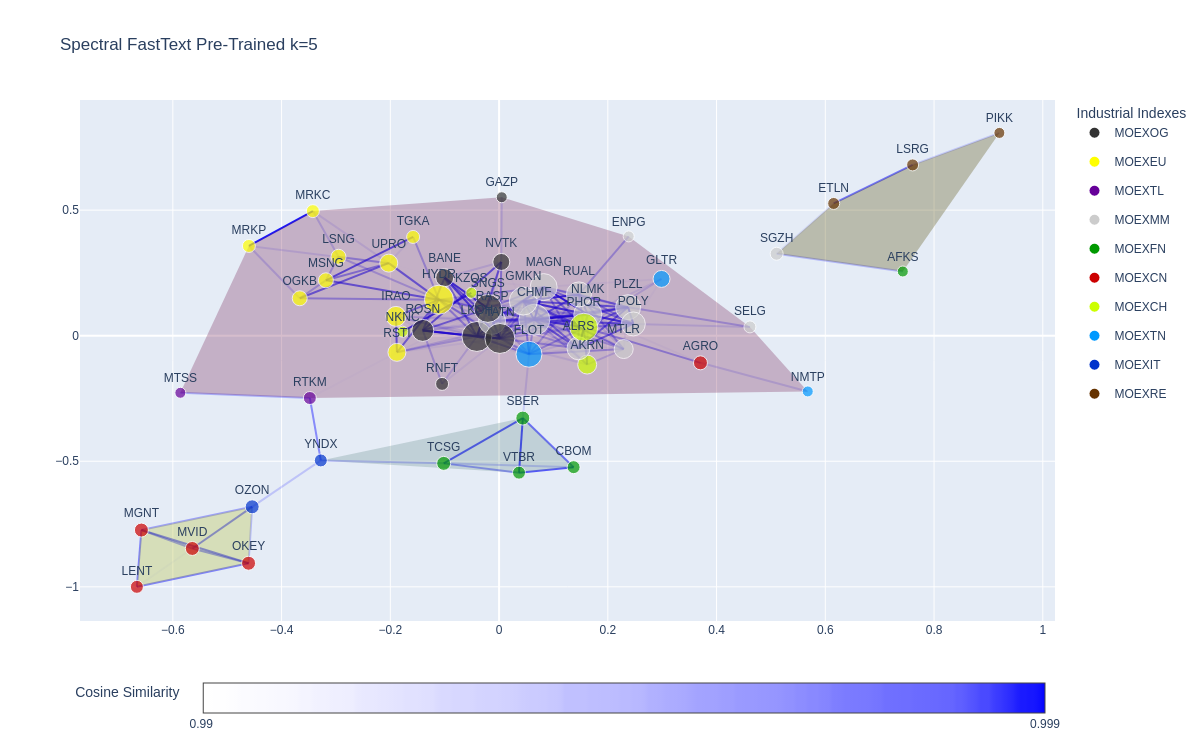

In [23]:
build_graph(edges, method='spectral', k=5, title='Spectral FastText Pre-Trained k=5')

> Too bad, everything is concentrated in same area, one cluster is too large.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



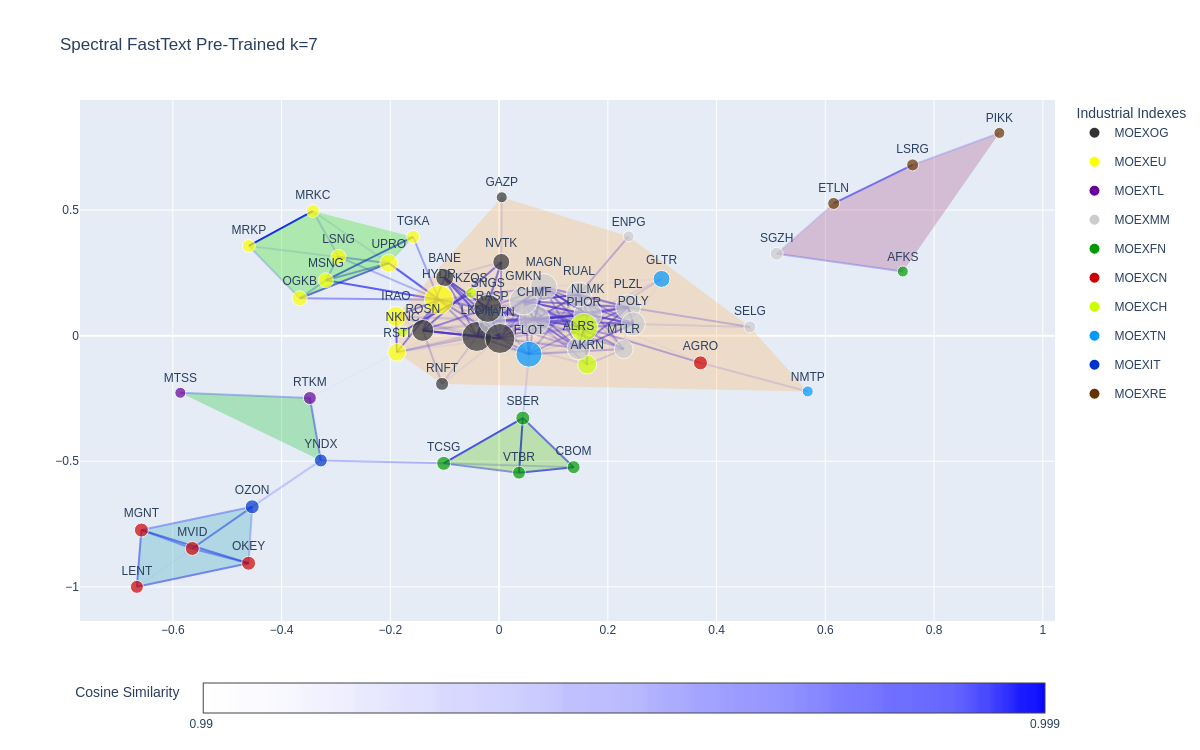

In [24]:
build_graph(edges, method='spectral', k=7, title='Spectral FastText Pre-Trained k=7')

> Now energy cluster is seen, but still too much companies in 1 cluster

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



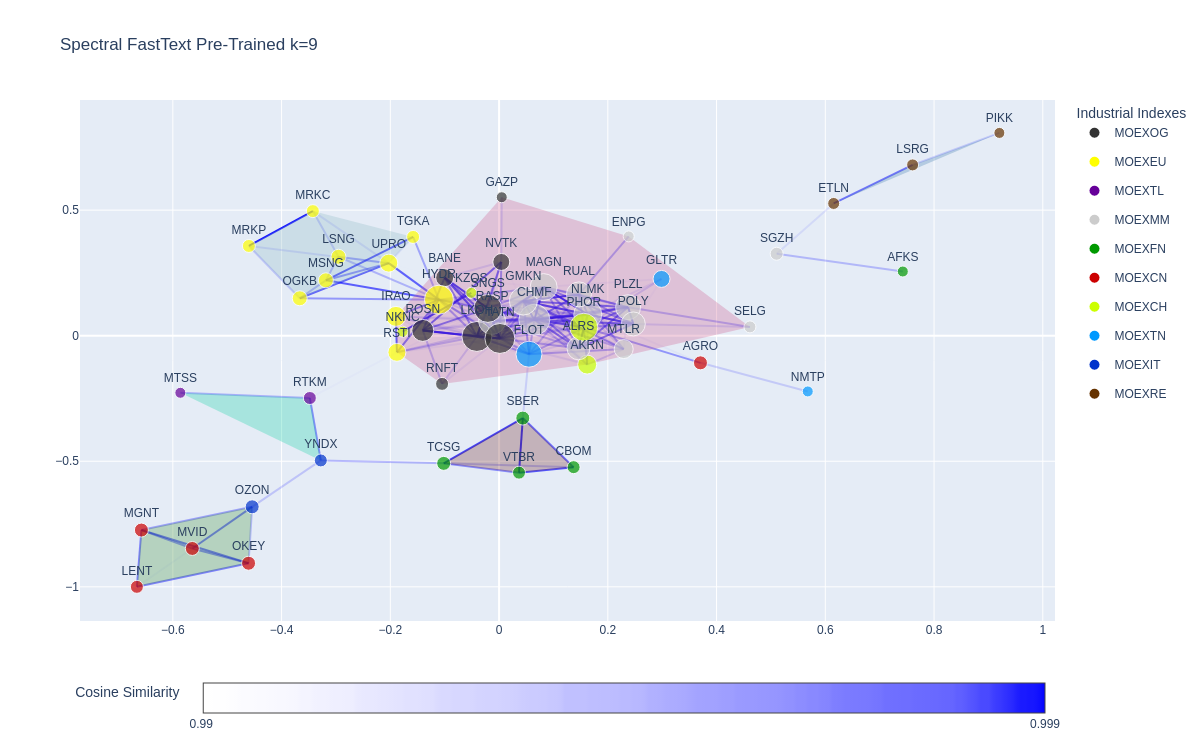

In [25]:
build_graph(edges, method='spectral', k=9, title='Spectral FastText Pre-Trained k=9')

> It becomes worse as real estate companies represent their own cluster

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



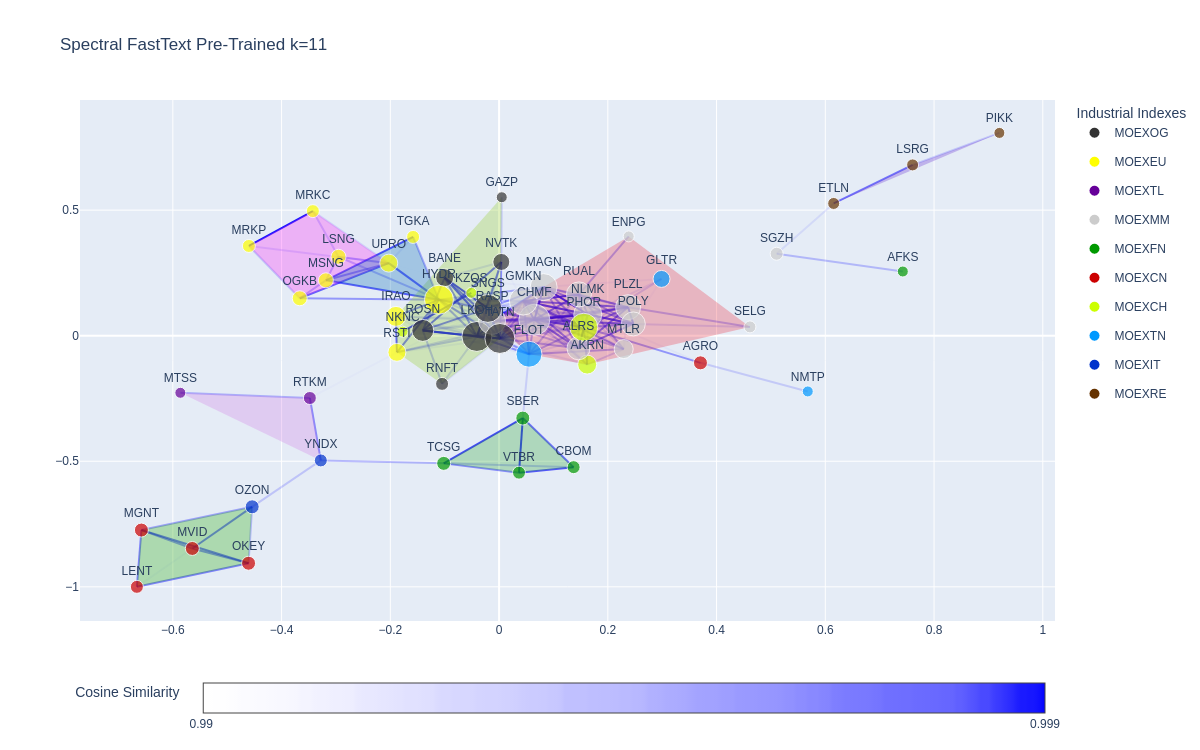

In [26]:
build_graph(edges, method='spectral', k=11, title='Spectral FastText Pre-Trained k=11')

> Looks better, manufacturers are splitted into oil and metal companies

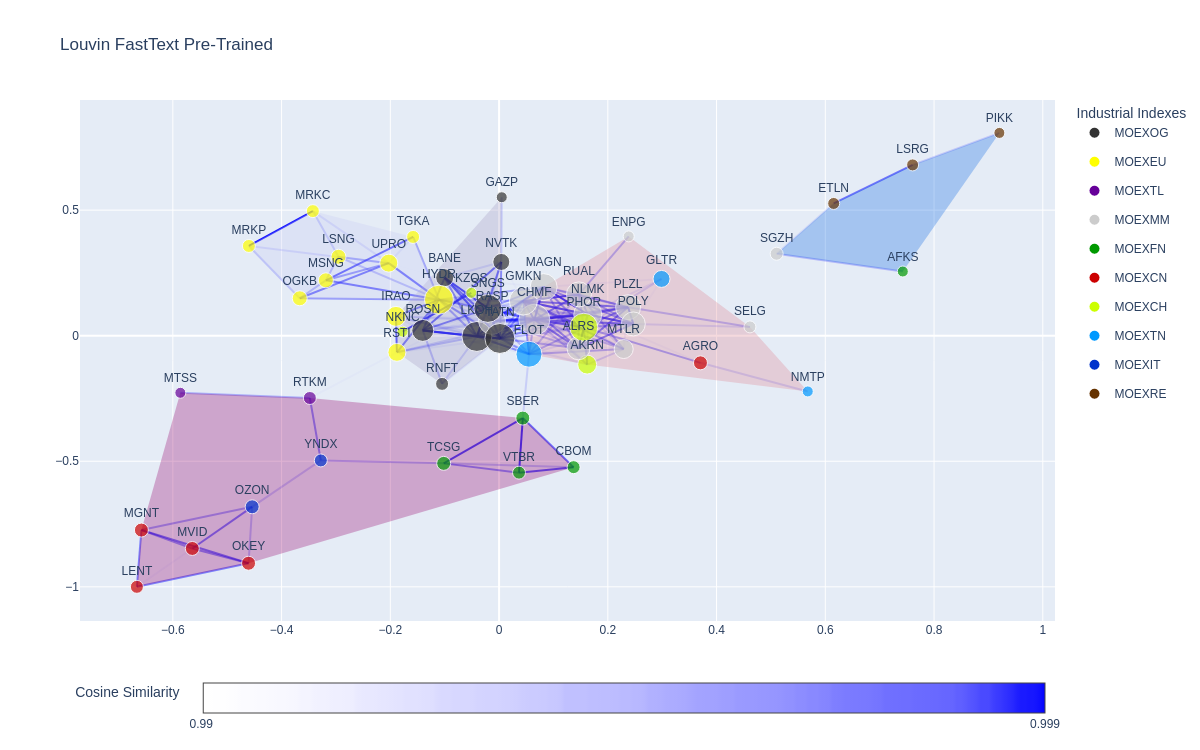

In [27]:
build_graph(edges, method='louvin', title='Louvin FastText Pre-Trained')

> Seems better than spectral in this case

> FastText pre-trained embeddings wasn't really helpful as cosine similarity between embeddings is too large and there are a lot of closely related companies in this case. However, it didn't catch some of connections, which tf-idf did (like ownership of MTSS by AFKS)

In [29]:
np.save('sim_matrix', similarity_mat)

In [30]:
np.save('embeddings', np.array(X_emb))

### FastText learn

In [12]:
model = FastText(sentences=texts_f_ft, vector_size=300, window=5, min_count=1, workers=4, sg=1)

In [13]:
def get_text_embeddings(text):

    embeddings = [model.wv[word] for word in text]
    return sum(embeddings) / len(embeddings)

In [14]:
X_emb_2 = []

In [15]:
for text in tqdm(texts):
    text_embedding = get_text_embeddings(text.split())
    X_emb_2.append(text_embedding)

100%|██████████| 91/91 [00:40<00:00,  2.23it/s]


In [16]:
edges = []
similarity_mat = cosine_similarity(X_emb_2)
for i in range(len(entities)):
    for j in range(i + 1, len(entities)):
        similarity = similarity_mat[i][j]
        if similarity > 0.998:
            edges.append((entities[i], entities[j], similarity))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


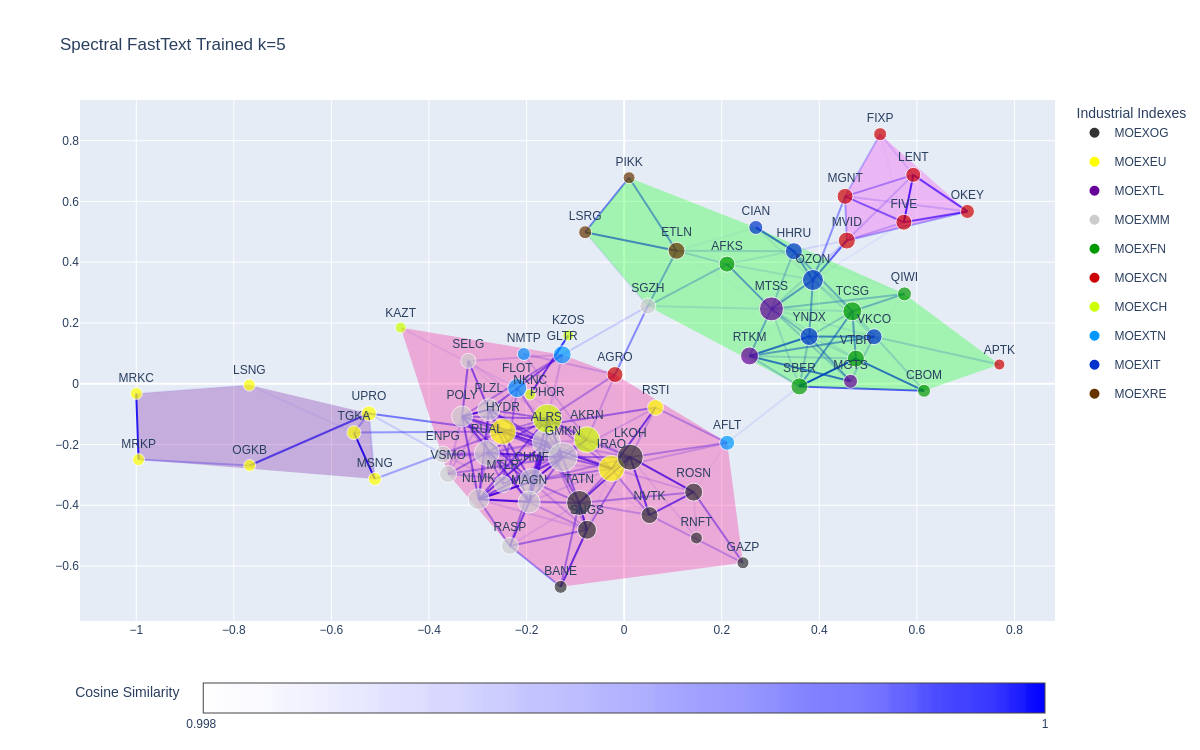

In [17]:
build_graph(edges, method='spectral', k=5, title='Spectral FastText Trained k=5')

> 4 large clusters can be clearly seen. But they are still too big

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



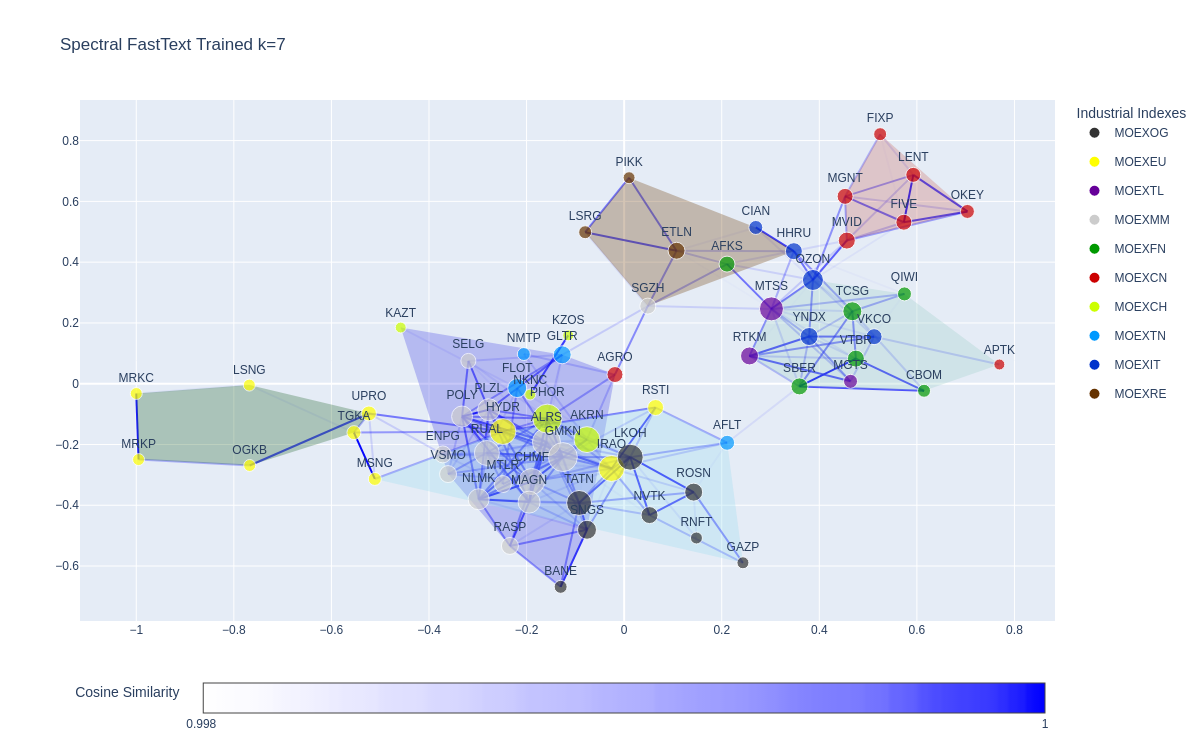

In [18]:
build_graph(edges, method='spectral', k=7, title='Spectral FastText Trained k=7')

> Real estate companies now have their cluster. Largest cluster splitted in 2, but they overlap. The possible reasoning behind this division is not clear.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



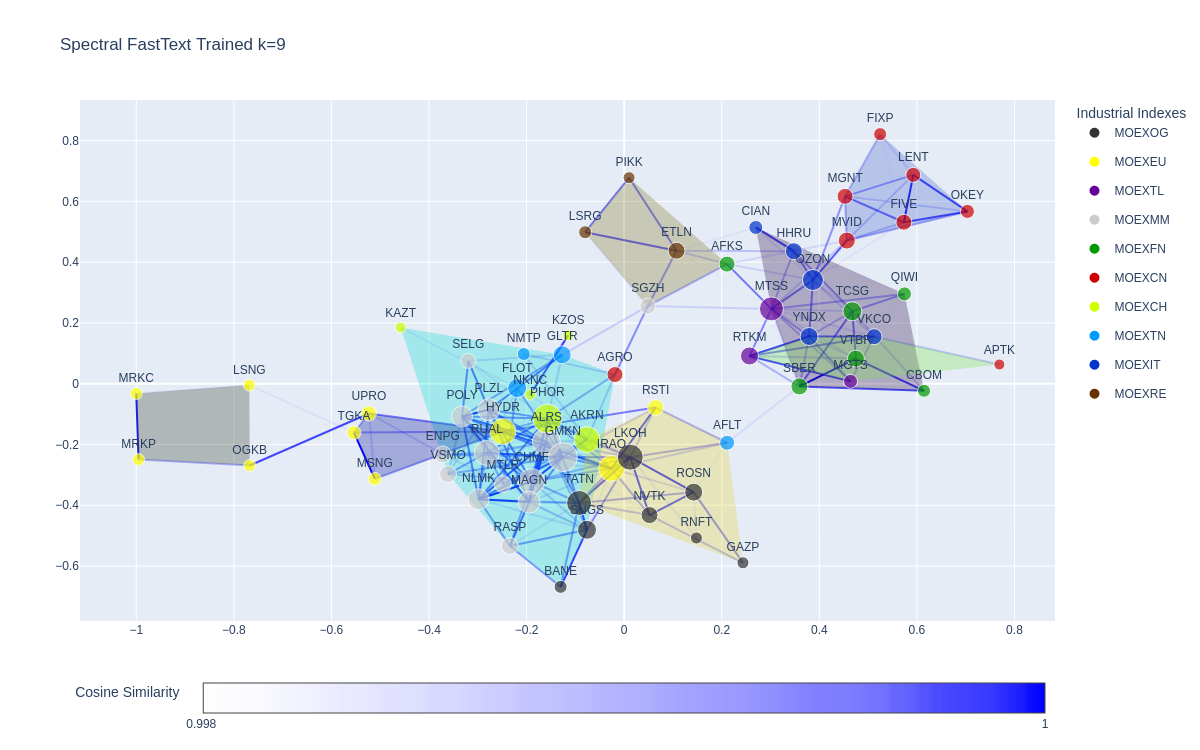

In [19]:
build_graph(edges, method='spectral', k=9, title='Spectral FastText Trained k=9')

> It looks much more strange. The principles of clustering are not clear, and the principles by which they intersect are also

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



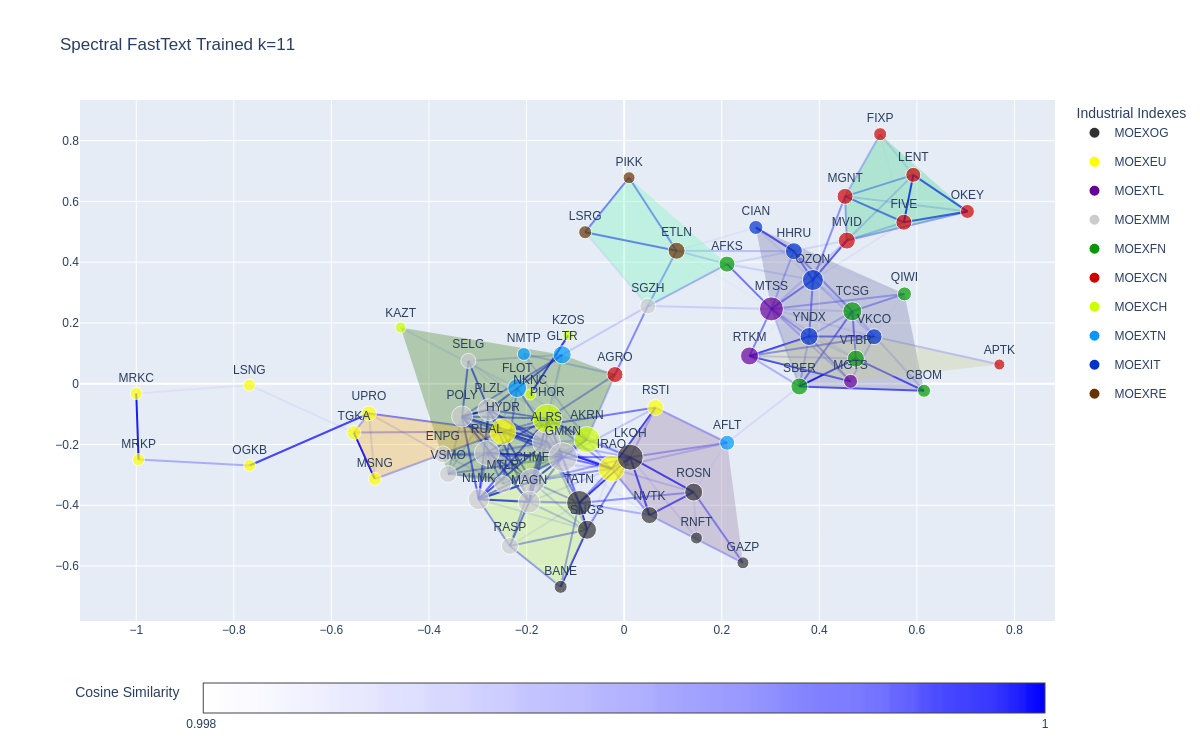

In [20]:
build_graph(edges, method='spectral', k=11, title='Spectral FastText Trained k=11')

> There is a feeling that there are too many clusters, their intersections are even more unclear

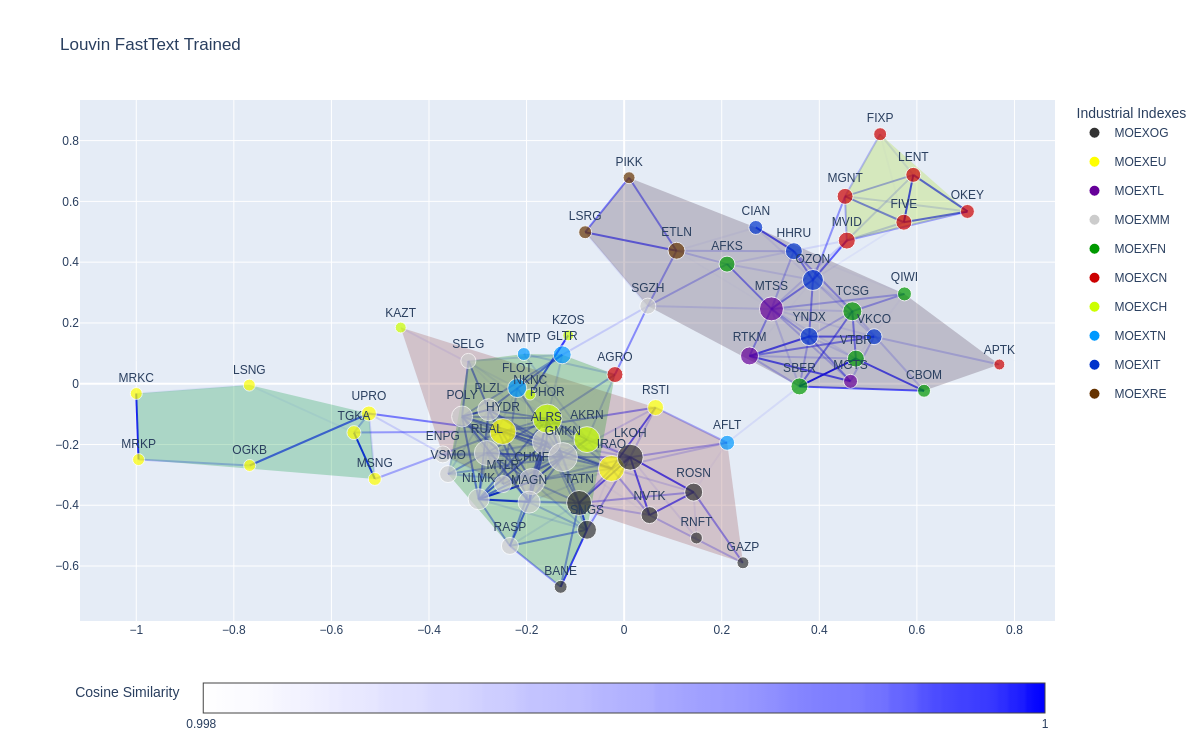

In [21]:
build_graph(edges, method='louvin', title='Louvin FastText Trained')

> There are also non-obvious clusters, it does not seem that they are meaningful

> Trained FastText performed even worse, embeddings are very similar

## Glove learn

In [22]:
from glove import Corpus, Glove

In [23]:
corpus = Corpus()

corpus.fit(texts_f_ft, window=10)

glove = Glove(no_components=300, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [24]:
def get_text_embeddings(text):
    embeddings = [glove.word_vectors[glove.dictionary[word]] for word in text]
    return sum(embeddings) / len(embeddings)

In [25]:
X_emb_3 = []

In [26]:
for text in tqdm(texts):
    text_embedding = get_text_embeddings(text.split())
    X_emb_3.append(text_embedding)

100%|██████████| 91/91 [00:25<00:00,  3.52it/s]


In [27]:
edges = []
similarity_mat = cosine_similarity(X_emb_3)
for i in range(len(entities)):
    for j in range(i + 1, len(entities)):
        similarity = similarity_mat[i][j]
        if similarity > 0.985:
            edges.append((entities[i], entities[j], similarity))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



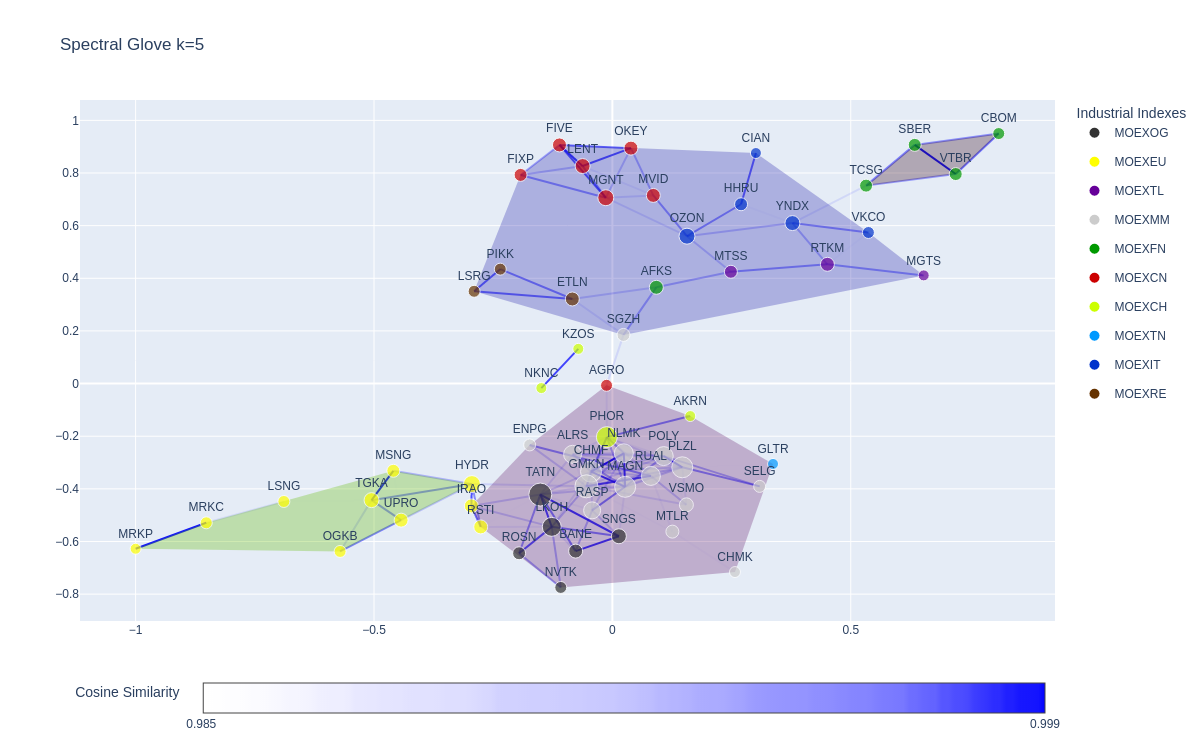

In [28]:
build_graph(edges, method='spectral', k=5, title='Spectral Glove k=5')

> As before, with a small k, the clusters are too large. Although in this case they look more or less meaningful

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



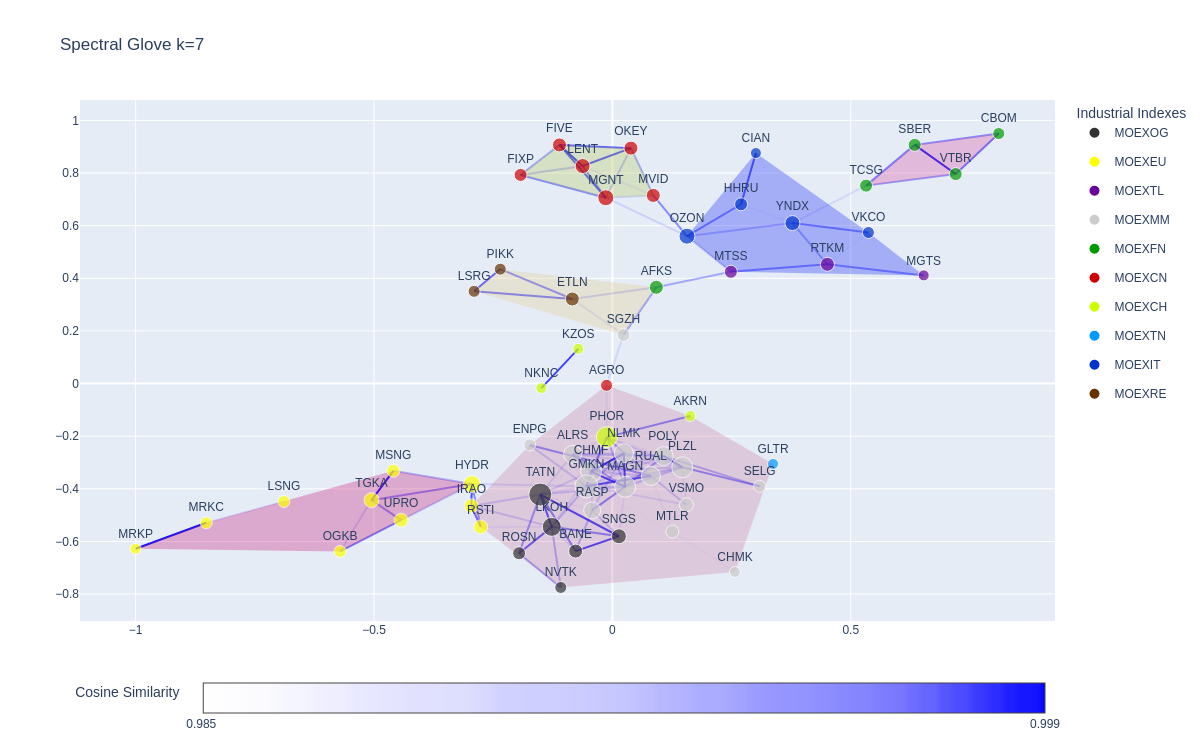

In [29]:
build_graph(edges, method='spectral', k=7, title='Spectral Glove k=7')

> It is better, now banks have their own cluster, real estate companies are in one cluster, as well as telecom and it. Still, the largest cluster is still too large.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



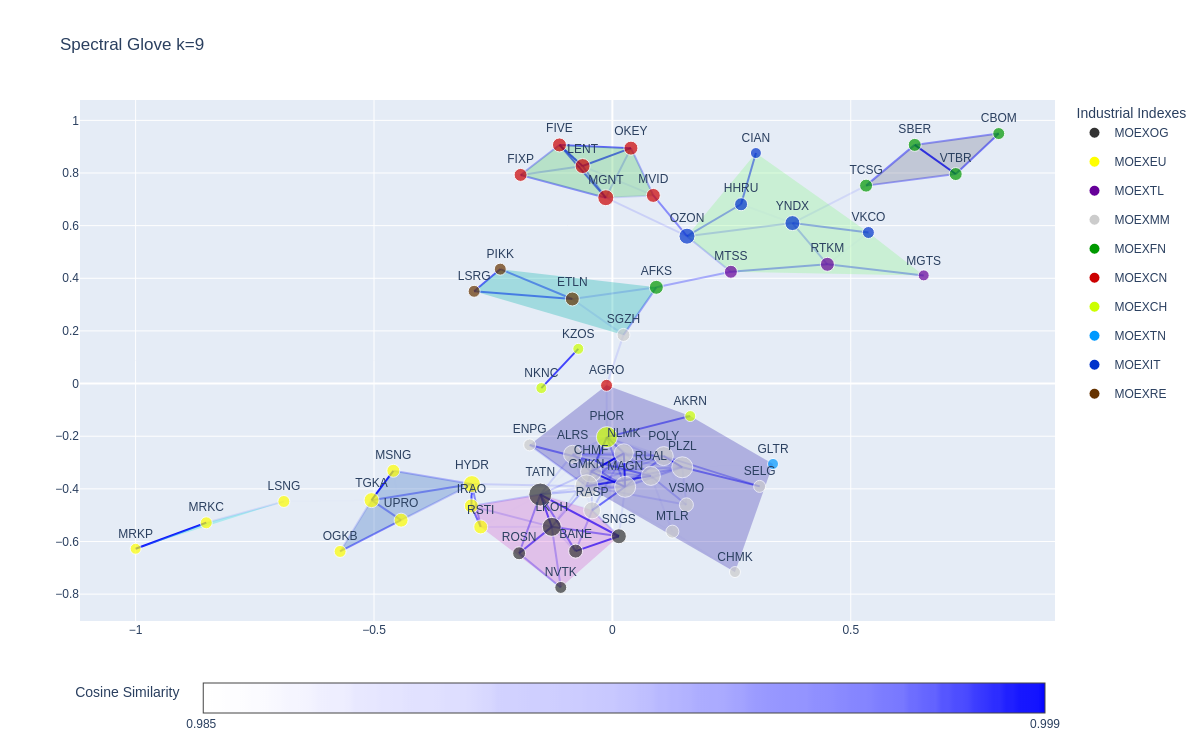

In [30]:
build_graph(edges, method='spectral', k=9, title='Spectral Glove k=9')

> It looks better than the previous one. Even metals and oil stood out separately. The only thing that is a little frustrating is the electric power industry

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



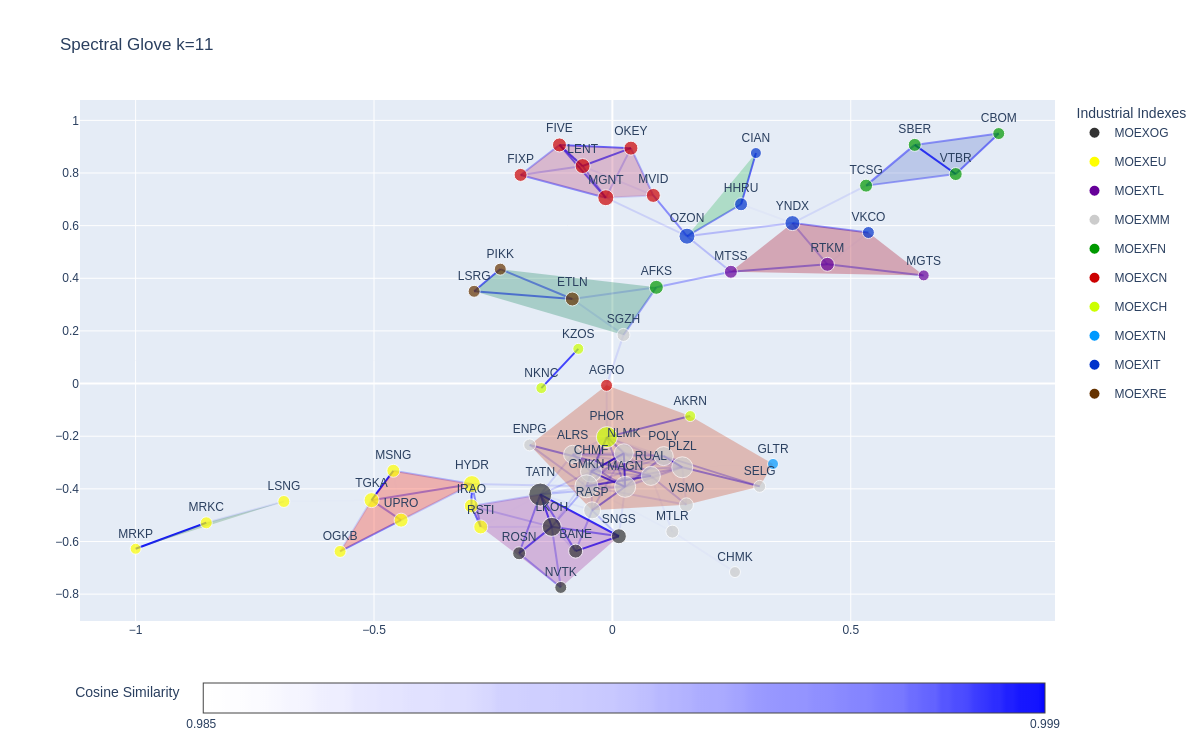

In [31]:
build_graph(edges, method='spectral', k=11, title='Spectral Glove k=11')

> Looks worse than previous, too many clusters

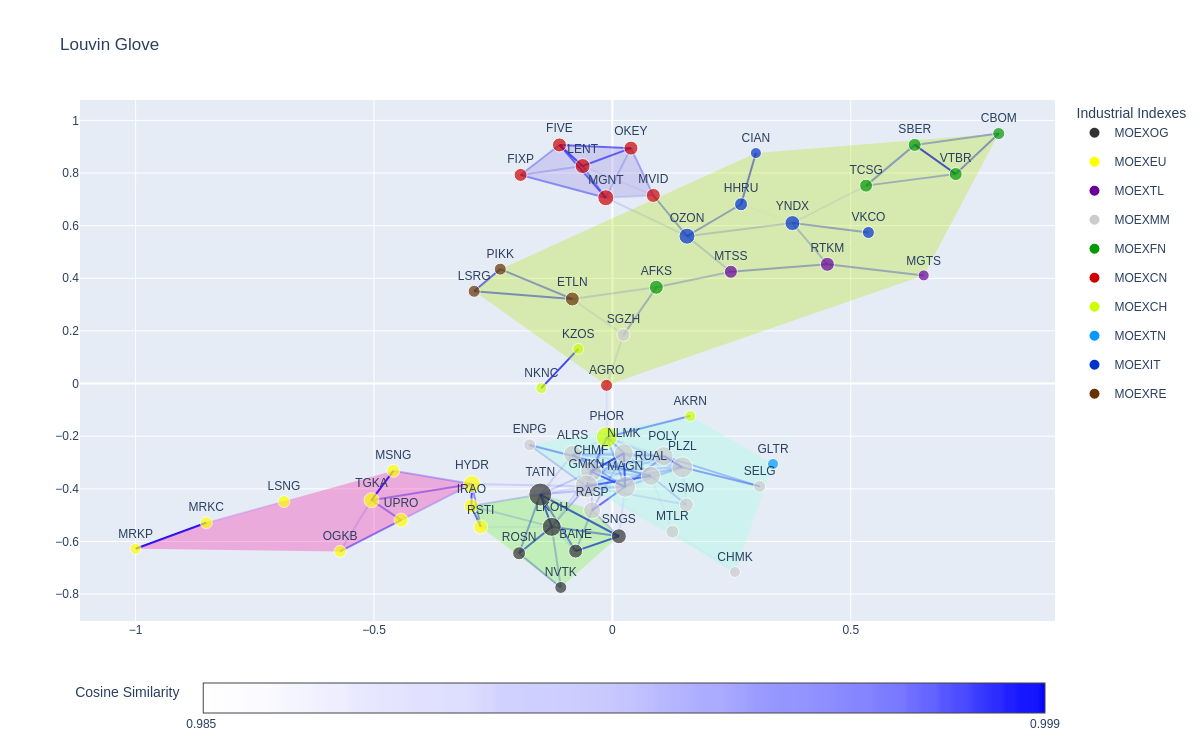

In [32]:
build_graph(edges, method='louvin', title='Louvin Glove')

> Very similar to the best of spectral clustering. It seems that some borderline cases are different.

> GloVe made it possible to draw a much more separable graph, so that clusters stand out very well, and they can be explained both in the case of spectral clustering and using the Louvin method

In [33]:
np.save('embeddings_glove', np.array(X_emb_3))